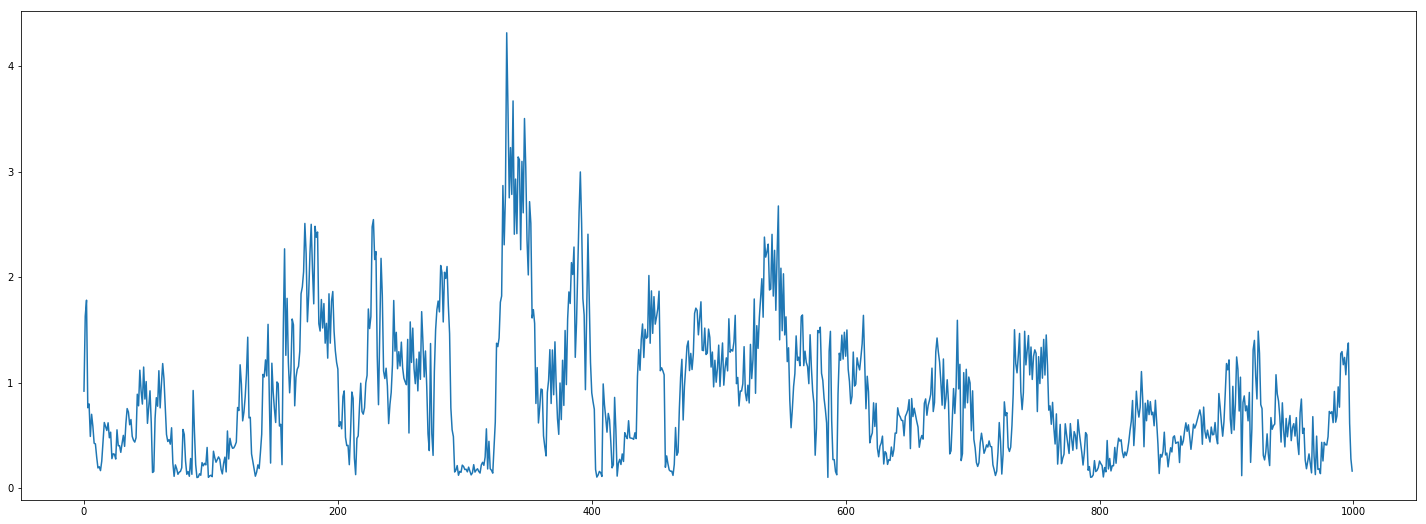

In [27]:
import pandas
import matplotlib.pyplot as plt
import numpy
import matplotlib.pyplot as plt
import pandas
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np


dataset = pandas.read_csv('train.csv', usecols=[1], engine='python')
dataset = dataset[:1000]
plt.figure(figsize=(25,9))
plt.plot(dataset)
plt.show()

In [28]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [3]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        
    return numpy.array(dataX), numpy.array(dataY)

In [4]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

trainY_inverse = scaler.inverse_transform([trainY])
testY_inverse = scaler.inverse_transform([testY])

 ---
 We have successfully loaded the data: trainX, trainY, testX, testY  
 Start initiating model and training

## Loss function using Mean Square Error

In [11]:
model_mse = Sequential()
model_mse.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model_mse.add(Dropout(0.2))
model_mse.add(LSTM(256, return_sequences = True))
model_mse.add(Dropout(0.2))
model_mse.add(LSTM(256, return_sequences = True))
model_mse.add(Dropout(0.2))
model_mse.add(LSTM(128, return_sequences = True))
model_mse.add(Dropout(0.2))
model_mse.add(LSTM(128))
model_mse.add(Dropout(0.2))

model_mse.add(Dense(1))
model_mse.compile(loss='mean_squared_error', optimizer='adam')

model_mse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 256)            264192    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 256)            525312    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 256)            525312    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 128)            197120    
__________

In [12]:
try:
    model_mse.fit(trainX, trainY, epochs = 100, batch_size= 1, verbose=2)
except KeyboardInterrupt:
    model_mse.save('model_mse.h5')

Epoch 1/100
36s - loss: 0.0127
Epoch 2/100


In [13]:
trainPredict = model_mse.predict(trainX)
testPredict = model_mse.predict(testX)

trainPredict_mse = scaler.inverse_transform(trainPredict)
testPredict_mse = scaler.inverse_transform(testPredict)

Train Score: 0.35 RMSE
Test Score: 0.23 RMSE


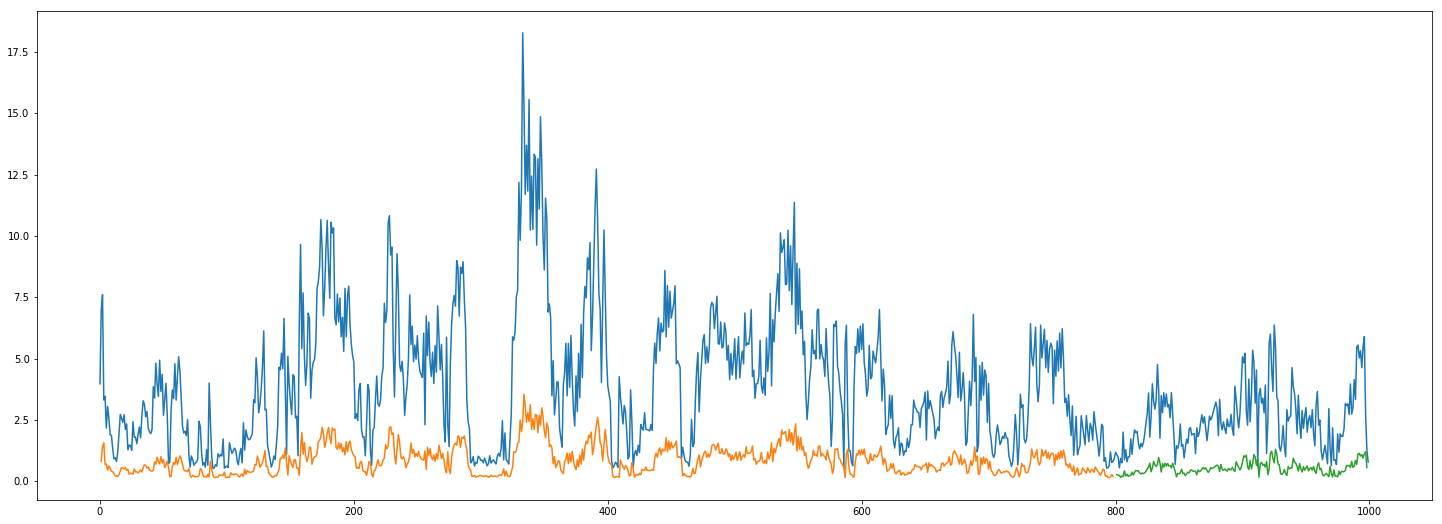

In [14]:
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict_mse[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict_mse[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict_mse
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict_mse
# plot baseline and predictions
plt.figure(figsize=(25,9))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Loss Function using MAPE

In [20]:
try: 
    model_mape = keras.models.load_model('model_mape.h5')
except:

    model_mape = Sequential()
    
    model_mape.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
    model_mape.add(Dropout(0.2))
    model_mape.add(LSTM(256, return_sequences = True))
    model_mape.add(Dropout(0.2))
    model_mape.add(LSTM(256, return_sequences = True))
    model_mape.add(Dropout(0.2))
    model_mape.add(LSTM(128, return_sequences = True))
    model_mape.add(Dropout(0.2))
    model_mape.add(LSTM(128))
    model_mape.add(Dropout(0.2))

    model_mape.add(Dense(1))
    model_mape.compile(loss='mean_absolute_percentage_error', optimizer='adam')

model_mape.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 1, 256)            264192    
_________________________________________________________________
dropout_26 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 1, 256)            525312    
_________________________________________________________________
dropout_27 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 1, 256)            525312    
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 1, 128)            197120    
__________

In [37]:
try:
    model_mape.fit(trainX, trainY, epochs = 100, batch_size= 1, verbose=2)
except KeyboardInterrupt:
    model_mape.save('model_mape.h5')

Epoch 1/100
31s - loss: 52072.7675
Epoch 2/100
30s - loss: 193226.4996
Epoch 3/100
29s - loss: 94305.1717
Epoch 4/100
29s - loss: 136068.1443
Epoch 5/100
31s - loss: 85795.1661
Epoch 6/100
29s - loss: 71044.2786
Epoch 7/100
30s - loss: 102927.6033
Epoch 8/100
30s - loss: 13229.3152
Epoch 9/100
31s - loss: 135314.2571
Epoch 10/100
30s - loss: 165042.6521
Epoch 11/100
30s - loss: 174218.9876
Epoch 12/100
31s - loss: 866.8169
Epoch 13/100
30s - loss: 196044.1241
Epoch 14/100
30s - loss: 49207.1076
Epoch 15/100
32s - loss: 116862.2784
Epoch 16/100
39s - loss: 35268.5608
Epoch 17/100
34s - loss: 108445.6044
Epoch 18/100
33s - loss: 47590.8388
Epoch 19/100
35s - loss: 78974.7439
Epoch 20/100
34s - loss: 58174.7533
Epoch 21/100
30s - loss: 45944.1561
Epoch 22/100
29s - loss: 110326.2441
Epoch 23/100
29s - loss: 133855.1666
Epoch 24/100
29s - loss: 63692.9755
Epoch 25/100
31s - loss: 69660.8247
Epoch 26/100
32s - loss: 77231.8763
Epoch 27/100
32s - loss: 10214.8401
Epoch 28/100
33s - loss: 180

In [38]:
trainPredict = model_mape.predict(trainX)
testPredict = model_mape.predict(testX)

trainPredict_mape = scaler.inverse_transform(trainPredict)
testPredict_mape = scaler.inverse_transform(testPredict)

Train Score: 10.29 RMSE
Test Score: 10.33 RMSE


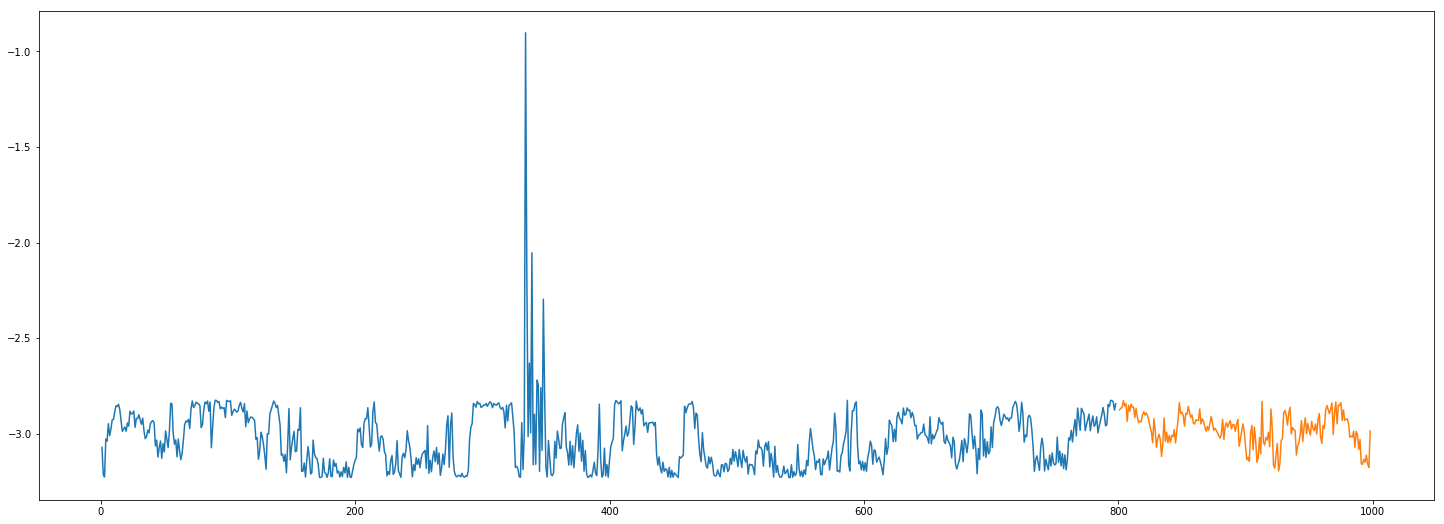

In [40]:
trainScore = math.sqrt(mean_absolute_percentage_error(trainY_inverse[0], trainPredict_mape[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_absolute_percentage_error(testY_inverse[0], testPredict_mape[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict_mape
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict_mape
# plot baseline and predictions
plt.figure(figsize=(25,9))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(100 * trainPredictPlot)
plt.plot(100 * testPredictPlot)
plt.show()